In [ ]:
import os
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# find device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print("Using {} device".format(device))

In [ ]:
class processDataset():
    def __init__(self, datasetPath, resize_size):
        self.uniqueClassNames = []   # [class1, class 2, class3, ...]
        self.imagesAndLabels = []    # [{images: tensor(30x224x224), label: class1}, ...]
        self.classNameToIndex = {}   # {class1: 0, class2: 1, class3: 2, ...}
        self.IndexToClassName = {}   # {0: class1, 1: class2, 2: class3, ...}
        self.allImages = []          # [tensor(30x224x224), tensor(30x224x224), tensor(30x224x224)]
        self.allLabels = []          # [class1, class3, class3, ...]
        self.transform = None
        self.NumFramesPerVid = 10
        
        # get class
        for className in os.listdir(datasetPath):
            if os.path.isdir(os.path.join(datasetPath, className)):
                self.uniqueClassNames.append(className)
        
        self.uniqueClassNames = set(self.uniqueClassNames)
        
        # (className -> index) & (index -> className) dict (unique)
        self.classNameToIndex = {className: i for i, className in enumerate(self.uniqueClassNames)}
        self.IndexToClassName = {i: className for i, className in enumerate(self.uniqueClassNames)}            
        
        # Image augmentation and normalisation transform
        self.transform = transforms.Compose([
            transforms.Resize((resize_size, resize_size)),  # Resizing for VGG input
            transforms.ToTensor(),          # Convert to tensor
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalisation
        ])
        
        # Collect Image Groups
        for className in self.uniqueClassNames:
            currClassFolder = os.path.join(datasetPath, className)
            allImagesInFolder = sorted([
                    f for f in os.listdir(currClassFolder)
                    if f.lower().endswith(('.jpg', '.png', '.jpeg'))
                ])
        
            # Group images by their file prefix
            imageGroups = {}
            for currImageName in allImagesInFolder:
                prefix = '_'.join(currImageName.split('_')[:-1])
                if prefix not in imageGroups:
                    imageGroups[prefix] = []
                imageGroups[prefix].append(currImageName)
                
            # For each group (video), we only proceed if exactly 10 frames exist
            for prefix, sortedImageList in imageGroups.items():
                if len(sortedImageList) == self.NumFramesPerVid:
                    # Sort frames by index (0001, 0002, ...)
                    sortedImageList = sorted(sortedImageList)
                    stackedImages = []
            
                    # Apply transform to each frame and stack them
                    for imName in sortedImageList:
                        imPath = os.path.join(currClassFolder, imName)
                        img = Image.open(imPath).convert('RGB')
                        img = self.transform(img)   # shape: [3, 224, 224]
                        stackedImages.append(img)

                    # concat along channel dimension => [30, 224, 224]
                    # (10 frames × 3 channels each = 30 channels)
                    stackedTensor = torch.cat(stackedImages, dim=0)

                    self.imagesAndLabels.append({
                        "images": stackedTensor,
                        "label": className
                    })
                else:
                    print(f"Warning: Skipping {prefix} because it does not have exactly {self.NumFramesPerVid} images (found {len(sortedImageList)}).")                
                
        for item in self.imagesAndLabels:
                self.allImages.append(item["images"])
                self.allLabels.append(self.classNameToIndex[item["label"]])   
        
        train_images, val_images, train_labels, val_labels = train_test_split(
            self.allImages, 
            self.allLabels, 
            test_size=0.2, 
            random_state=42            
        )

        self.train_images = torch.stack(train_images, dim=0)  # [N, 30, 224, 224]
        self.val_images   = torch.stack(val_images,   dim=0)  # [N, 30, 224, 224]
        self.train_labels = torch.tensor(train_labels, dtype=torch.long)
        self.val_labels   = torch.tensor(val_labels,   dtype=torch.long) 
        
        # Compute Class Weights
        train_labels_np = self.train_labels.numpy()
        classes = np.unique(train_labels_np)  
        class_weights = compute_class_weight(
            class_weight='balanced', 
            classes=classes, 
            y=train_labels_np
        )        
        
        _, label_count = np.unique(self.train_labels, return_counts=True)

        # Convert to a PyTorch tensor and move to device
        self.class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
        
datasetPath = r""
dataset = processDataset(datasetPath, 224)  

### Unit tests:

In [ ]:
# a) Load dataset test
print("Total samples in dataset:", len(dataset.imagesAndLabels))
first_sample = dataset.imagesAndLabels[0]
print("First sample image tensor shape:", first_sample["images"].shape)
assert first_sample["images"].shape == (30, 224, 224), "Fail: Image tensor does not have 30 channels"
# Expected output: 
# Total samples in dataset: 3
# First sample image tensor shape: torch.Size([30, 224, 224])

# b) Class mappings test
print("\nClass name to index:", dataset.classNameToIndex)
print("Index to class name:", dataset.IndexToClassName)
# Expected output: 
# Class name to index: {'colon_lymphoma': 0, 'acanthosis_nigricans': 1}
# Index to class name: {0: 'colon_lymphoma', 1: 'acanthosis_nigricans'}

# c) Split test
assert dataset.train_images.shape[1:] == (30, 224, 224), "Error: Train images not in correct format"
assert dataset.val_images.shape[1:] == (30, 224, 224), "Error: Validation images not in correct format"
print("\nTrain set size:", dataset.train_images.shape[0])
print("Validation set size:", dataset.val_images.shape[0])
# Expected output:
# Train set size: 2
# Validation set size: 1

Total samples in dataset: 3
First sample image tensor shape: torch.Size([30, 224, 224])

Class name to index: {'acanthosis_nigricans': 0, 'colon_lymphoma': 1}
Index to class name: {0: 'acanthosis_nigricans', 1: 'colon_lymphoma'}

Train set size: 2
Validation set size: 1


### Visual Testing:

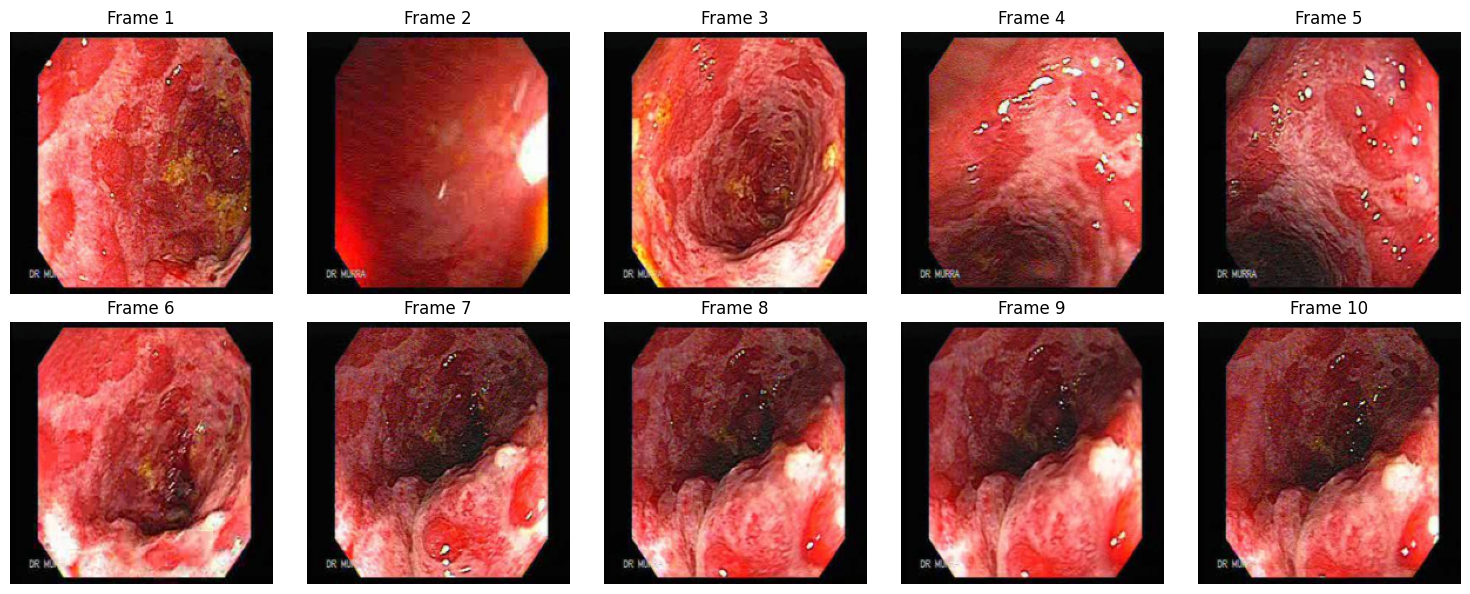

In [ ]:
# Get frame function
def show_frame(imgTensor, frameIdx, ax):
    img = imgTensor[frameIdx * 3: (frameIdx + 1) * 3, :, :].numpy().transpose((1, 2, 0))
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.set_title(f"Frame {frameIdx+1}", fontsize=12)
    ax.axis("off")

# First concatenated matrix group
imgGroup = dataset.imagesAndLabels[2]["images"]  # Shape: [30, 224, 224]

# Show 10 frames in a grid (2 rows × 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    show_frame(imgGroup, i, ax)

plt.tight_layout()
plt.show()

### Integration test:

In [ ]:
# Load VGG model
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=False)

# Modify first conv layer to take 30 channels instead of 3
model.features[0] = nn.Conv2d(in_channels=30, out_channels=64, kernel_size=3, stride=1, padding=1)
num_classes = 2  # Modify classifier for correct output classes
model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)
model.to(device)

sample_batch = next(iter(dataset.train_images))
sample_batch = sample_batch.unsqueeze(0).to(device)

outputs = model(sample_batch)  # Perform forward pass

print("Output shape:", outputs.shape)  # Expecting [1, 2]
# Expected output: torch.Size([1, 2])